In [2]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [6]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
arxiv.name

'arxiv'

In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [14]:
wiki.invoke("BCCI")

'Page: Board of Control for Cricket in India\nSummary: The Board of Control for Cricket in India (BCCI) is the principal national governing body of the sport of cricket in India. Its headquarters are situated at the Cricket Centre in Wankhede Stadium, Mumbai. BCCI is the wealthiest governing body of cricket in the world. It has a revenue of more than 9,700 crore.\nIt is involved in talent development through grassroots programs and cricket academies. Its initiatives include coaching, infrastructure'

In [30]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['TAVILTY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')
os.environ['LANGCHAIN_API_KEY']=os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_PROJECT']='ReAct_agent'

In [16]:
## custom functions
def add(a: float, b: float) -> float:
    """
    Add two numbers together.

    Args:
        a (float): The first number.
        b (float): The second number.

    Returns:
        float: The sum of a and b.
    """
    return a + b


def sub(a: float, b: float) -> float:
    """
    Subtract one number from another.

    Args:
        a (float): The number from which b will be subtracted.
        b (float): The number to subtract from a.

    Returns:
        float: The result of a - b.
    """
    return a - b


def multi(a: float, b: float) -> float:
    """
    Multiply two numbers.

    Args:
        a (float): The first number.
        b (float): The second number.

    Returns:
        float: The product of a and b.
    """
    return a * b


def divide(a: float, b: float) -> float:
    """
    Divide one number by another.

    Args:
        a (float): The numerator (the number to be divided).
        b (float): The denominator (the number by which a is divided).
                   Must not be zero.

    Returns:
        float: The result of a / b.

    Raises:
        ValueError: If b is zero.
    """
    if b == 0:
        raise ValueError("Division by zero is not allowed.")
    return a / b


In [18]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily=TavilySearchResults()

/tmp/ipykernel_139909/3880125110.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [19]:
tavily.invoke("openai's new chat model")

[{'title': 'Model Release Notes - OpenAI Help Center',
  'url': 'https://help.openai.com/en/articles/9624314-model-release-notes',
  'content': 'GPT-5 in ChatGPT is our next flagship model and the new default for all logged-in users. It simplifies ChatGPT to a single auto-switching system that brings together the best of our previous models into asmart, fast model. [...] We’re releasing a research preview of GPT-4.5—our largest, and best model for chat, yet. GPT-4.5 is a step forward in scaling up pretraining and post-training. By scaling unsupervised learning, GPT-4.5 improves its ability to recognize patterns, draw connections, and generate creative insights without reasoning. [...] This model is now available in ChatGPT and in the API as the newest snapshot of chatgpt-4o-latest. We plan to bring these improvements to a dated model in the API in the coming weeks.\n\nIntroducing GPT-4.5 (February, 27, 2025)',
  'score': 0.8266142},
 {'title': 'OpenAI launches new GPT-5 model for all C

In [20]:
tools=[arxiv,wiki,tavily,add,sub,multi,divide]

In [32]:
from langchain_openai import ChatOpenAI


llm=ChatOpenAI(model="gpt-4o-mini")
llm_with_tools=llm.bind_tools(tools)

In [23]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [24]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

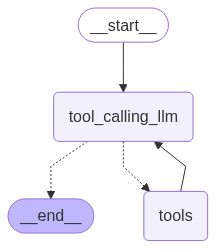

In [33]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top5 ai news for sep 8th 25,add 5 plus 5 and then divide by 10")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Provide me the top5 ai news for sep 8th 25,add 5 plus 5 and then divide by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_DTnffAKtmC8lgY6Oalw9Edvi)
 Call ID: call_DTnffAKtmC8lgY6Oalw9Edvi
  Args:
    query: AI news September 8 2025
  add (call_I4y0BQjhCFaMMvJmuF96qbex)
 Call ID: call_I4y0BQjhCFaMMvJmuF96qbex
  Args:
    a: 5
    b: 5
  divide (call_dKqDOwflGZWc8SD1XcA2dQid)
 Call ID: call_dKqDOwflGZWc8SD1XcA2dQid
  Args:
    a: 10
    b: 1
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Artificial Intelligence - AI News - Reuters", "url": "https://www.reuters.com/technology/artificial-intelligence/", "content": "Published Time: Mon, 08 Sep 2025 16:41:26 GMT\n\nAI News | Latest Headlines and Developments | Reuters\n\nSkip to main content\n\nRepor

### Agents with Memory
- MemorySaver

In [35]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

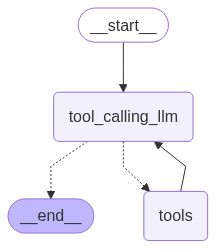

In [36]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
##
from langgraph.checkpoint.memory import MemorySaver


memory=MemorySaver()

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

graph_memory=builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [37]:
## specify the thread


config={"configurable":{"thread_id":"1"}}

messages=[HumanMessage(content="Add 5 plus 7")]
messages=graph_memory.invoke({"messages":messages},config=config)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 5 plus 7
================================== Ai Message ==================================
Tool Calls:
  add (call_LJVMwZTDBJb2AXtF929QUY1I)
 Call ID: call_LJVMwZTDBJb2AXtF929QUY1I
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

12.0
================================== Ai Message ==================================

5 plus 7 equals 12.


In [38]:
messages=[HumanMessage(content="multiply that number with 2")]
messages=graph_memory.invoke({"messages":messages},config=config)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 5 plus 7
================================== Ai Message ==================================
Tool Calls:
  add (call_LJVMwZTDBJb2AXtF929QUY1I)
 Call ID: call_LJVMwZTDBJb2AXtF929QUY1I
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

12.0
================================== Ai Message ==================================

5 plus 7 equals 12.
================================ Human Message =================================

multiply that number with 2
================================== Ai Message ==================================
Tool Calls:
  multi (call_IshwhqiCtDdjMfbcdrFw4J62)
 Call ID: call_IshwhqiCtDdjMfbcdrFw4J62
  Args:
    a: 12
    b: 2
================================= Tool Message =================================
Name: multi

24.0
================================== Ai Message ==================================

Multiplying 12 by 